In [25]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from myutils import (
    get_rolling_kelly, process_data, get_historical_var, calculate_daily_rf, get_cumulative_returns
)

In [26]:
rebalance_interval = 60
var_confidence = 0.05
window = 400

In [27]:
# 데이터 겟
sp500 = pd.read_csv('SP500_mine.csv')
sp500 = process_data(sp500)

# rf 추가
rf = pd.read_csv('rf_data.csv')
rf.columns = ['Date', 'rf']
rf = calculate_daily_rf(rf, 250)
sp500 = sp500.join(rf)
sp500['rf'] = sp500['rf'].ffill()

In [4]:
# VaR 계산
sp500_var = get_historical_var(sp500, window, var_confidence)

In [5]:
# Kelly 계산
rolling_kelly = get_rolling_kelly(sp500_var)
sp500_var['kelly'] = rolling_kelly

In [6]:
# 정해둔 시점에 대한 값만 겟
index_location = sp500_var.index.get_loc('01/08/2009')
sp500_target = sp500_var.iloc[index_location+1:]

### sp500 단순 보유 수익률

In [7]:
# sp500_target['CumReturn_temp'] = sp500_target['Change']+1
# sp500_target['CumReturn'] = sp500_target['CumReturn_temp'].cumprod()
# sp500_target['CumReturn'].plot()

/var/folders/yz/s1q6x0ws0mq8fpv7l4vlz9_c0000gn/T/ipykernel_63378/3255616090.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sp500_target['rf_CumReturn_temp'] = sp500_target['rf']+1
/var/folders/yz/s1q6x0ws0mq8fpv7l4vlz9_c0000gn/T/ipykernel_63378/3255616090.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sp500_target['rf_CumReturn'] = sp500_target['rf_CumReturn_temp'].cumprod()


<Axes: xlabel='Date'>

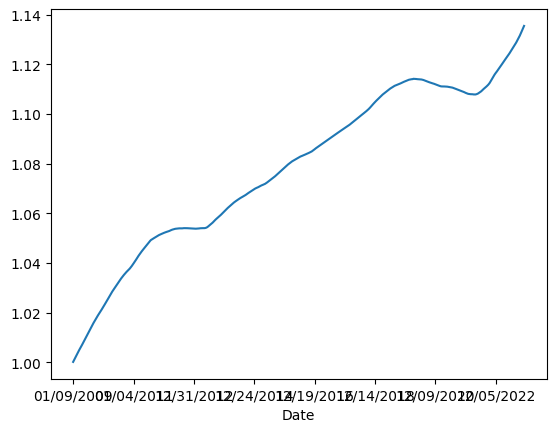

In [8]:
sp500_target['rf_CumReturn_temp'] = sp500_target['rf']+1
sp500_target['rf_CumReturn'] = sp500_target['rf_CumReturn_temp'].cumprod()
sp500_target['rf_CumReturn'].plot()

### Kelly 지수 관련 시각화

In [9]:
sp500_target['kelly'].describe()

count    3736.000000
mean        4.960530
std         5.430819
min        -3.384364
25%         1.206524
50%         3.063524
75%         8.307597
max        34.850058
Name: kelly, dtype: float64

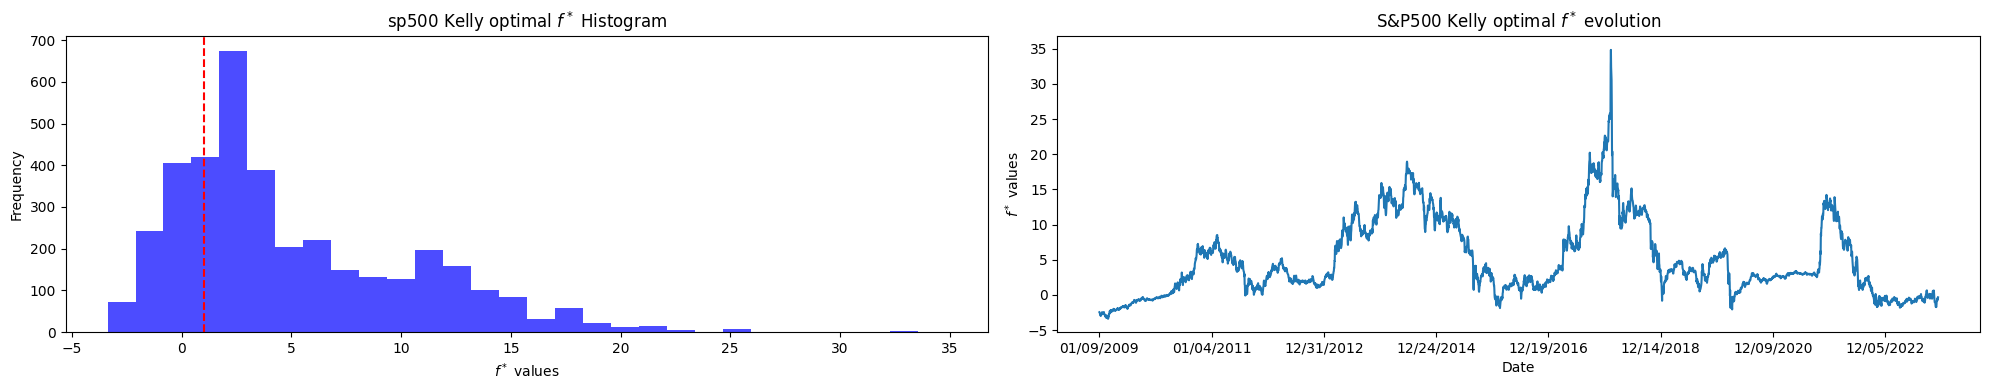

In [10]:
# 서브플롯 설정
fig, ax = plt.subplots(ncols=2, figsize=(20, 4))

# Kospi Kelly optimal f* 히스토그램
ax[0].hist(sp500_target['kelly'], bins=30, color='blue', alpha=0.7)
ax[0].set_xlabel('$f^*$ values')
ax[0].set_ylabel('Frequency')
ax[0].set_title('sp500 Kelly optimal $f^*$ Histogram')
ax[0].axvline(x=1, color='red', linestyle='--')

sp500_target['kelly'].plot(ax=ax[1])
ax[1].set_ylabel('$f^*$ values');
ax[1].set_title('S&P500 Kelly optimal $f^*$ evolution');

plt.savefig(f'result/kelly: rebalance_{str(rebalance_interval)}, var_{str(var_confidence)}, window_{str(window)}.png')

plt.tight_layout()
plt.show()

### 다시 캘리

In [11]:
# sp500_target['kelly_ratio'] = sp500_target['kelly'] / 100
sp500_target['kelly_ratio'] = sp500_target['kelly']

/var/folders/yz/s1q6x0ws0mq8fpv7l4vlz9_c0000gn/T/ipykernel_63378/3592935947.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sp500_target['kelly_ratio'] = sp500_target['kelly']


In [28]:
sp500_target.head(5)

,Price,Open,High,Low,Change %,Change,rf,VaR,kelly,rf_CumReturn_temp,rf_CumReturn,kelly_ratio,portfolio,equity,cash
Date,,,,,,,,,,,,,,,
01/09/2009,890.35,909.91,911.93,888.31,-2.13%,-0.0213,0.000097,-0.0320,-2.466456,1.000097,1.000097,-2.466456,1.000000,-2.466456,3.466456
01/12/2009,870.26,890.40,890.40,864.32,-2.26%,-0.0226,0.000093,-0.0320,-2.515697,1.000093,1.000190,-2.515697,1.000000,-2.410714,3.466778
01/13/2009,871.79,869.79,877.02,862.02,0.18%,0.0018,0.000091,-0.0320,-2.584317,1.000091,1.000280,-2.584317,1.056064,-2.415053,3.467092
01/14/2009,842.62,867.28,867.28,836.93,-3.35%,-0.0335,0.000091,-0.0335,-2.770916,1.000091,1.000371,-2.770916,1.052039,-2.334149,3.467407
01/15/2009,843.74,841.99,851.59,817.04,0.13%,0.0013,0.000093,-0.0335,-2.803653,1.000093,1.000465,-2.803653,1.133258,-2.337183,3.467731


In [12]:
sp500_zero_kelly = sp500_target.copy()
sp500_zero_kelly['kelly_ratio'] = sp500_zero_kelly['kelly_ratio'].apply(lambda x: x if x>0 else 0)

In [13]:
def update_kelly(row):
    if row['VaR'] >= row['Change']:
        return 0
    else:
        return row['kelly_ratio']
    
sp500_result_var_kelly = sp500_zero_kelly.copy()
# apply 함수를 사용하여 kelly_ratio 업데이트
sp500_result_var_kelly['kelly_ratio'] = sp500_result_var_kelly.apply(lambda row: update_kelly(row), axis=1)

In [14]:
sp500_result = get_cumulative_returns(sp500_target, rebalance_interval)
sp500_result_zero_kelly = get_cumulative_returns(sp500_zero_kelly, rebalance_interval)
sp500_result_var_kelly = get_cumulative_returns(sp500_result_var_kelly, rebalance_interval)

/Users/kimjihyo/Documents/GitHub/The-Kelly-Criterion/myutils.py:95: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[:, 'portfolio'] = portfolio
/Users/kimjihyo/Documents/GitHub/The-Kelly-Criterion/myutils.py:96: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[:, 'equity'] = equity
/Users/kimjihyo/Documents/GitHub/The-Kelly-Criterion/myutils.py:97: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See

In [15]:
sp500_result_var_kelly.to_csv(f'result/all_data: rebalance_{str(rebalance_interval)}, var_{str(var_confidence)}, window_{str(window)}.csv')

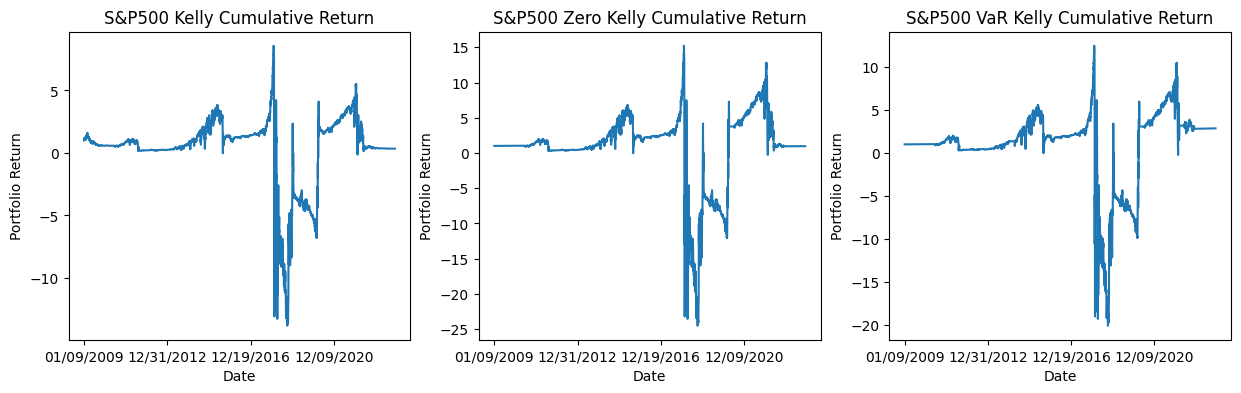

In [16]:
fig, ax = plt.subplots(ncols=3, figsize=(15, 4))

sp500_result['portfolio'].plot(ax=ax[0])
ax[0].set_ylabel('Portfolio Return');
ax[0].set_title('S&P500 Kelly Cumulative Return');

sp500_result_zero_kelly['portfolio'].plot(ax=ax[1])
ax[1].set_ylabel('Portfolio Return');
ax[1].set_title('S&P500 Zero Kelly Cumulative Return');

sp500_result_var_kelly['portfolio'].plot(ax=ax[2])
ax[2].set_ylabel('Portfolio Return');
ax[2].set_title('S&P500 VaR Kelly Cumulative Return');


plt.savefig(f'result/Returns: rebalance_{str(rebalance_interval)}, var_{str(var_confidence)}, window_{str(window)}.png')